## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 70 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 60.6 MB/s 
     |████████████████████████████████| 112 kB 78.3 MB/s 
     |████████████████████████████████| 45 kB 2.0 MB/s 
     |████████████████████████████████| 288 kB 81.5 MB/s 
     |████████████████████████████████| 144 kB 60.0 MB/s 
     |████████████████████████████████| 271 kB 77.5 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 749 kB 74.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169214, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 1000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 1000 steps
Generated time-series
Normalized 'candles_norm' with shape : (1000, 9)
Feature data 'x_candles' with size : 952
Feature data with time intervals 'x_time' with size : 952


In [6]:
USE_PRETRAINED = True
PRESAVED_MODELDATE='220615_18_16'
initial_timestamp = pd.Timestamp(datetime.strptime('220615_18_16', '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
preds = ts_btc.denorm(loaded_model.preds)

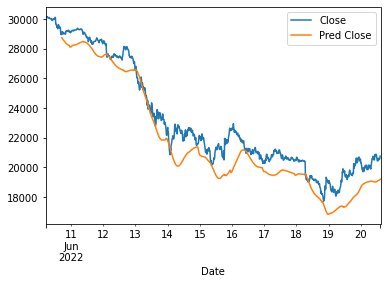

In [11]:
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.iloc[-1000:].plot()

In [31]:
def kelly_expression(return_history, investment = 1000):

  drift = np.mean(return_history)
  variance = np.var(return_history)
  kelly_frac = drift/variance
  optimal_investment = kelly_frac* investment

  return optimal_investment


def backtest_df(df_preds_true, long_or_short = "long", fee=0.025):

    if long_or_short == "short":
            long = False
    elif long_or_short == "long":
            long = True
    else:
        raise ValueError("Can only have long or short")

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    previous_true_close = df_preds_true.iloc[0,0]
    previous_pred_close = df_preds_true.iloc[0,-1]

    for index, row in df_preds_true.iloc[1:].iterrows():
        true_close = row[0]
        pred_close = row[-1]

        if long:
            if previous_pred_close + previous_true_close * fee < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

            previous_true_close = true_close
            previous_pred_close = pred_close

        else:
            if  previous_pred_close + previous_true_close *fee > pred_close:  # short
                profit = true_close - previous_true_close
                if profit < 0:
                    # win
                    profit = -1*(profit - (profit * fee))
                    buys_cnt_win += 1
                    old_profit_negative = False
                    print(f"profit {profit}")
                    print(f"{index}, true {true_close}, pred {pred_close}")
                    print(f"prev true {previous_true_close}, prev pred {previous_pred_close}")                    
                else:
                    #loss
                    profit = -1*(profit + (profit * fee))
                    buys_cnt_losses += 1
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

            previous_true_close = true_close
            previous_pred_close = pred_close
    
    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('No-op   ', len(df_preds_true) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

profit 29.10374999999858
2022-06-10 17:31:00, true 29127.33, pred 28679.956247922768
prev true 29157.18, prev pred 28709.565920618166
profit 12.012000000003264
2022-06-10 17:46:00, true 29115.01, pred 28644.991564777483
prev true 29127.33, prev pred 28679.956247922768
profit 10.00349999999844
2022-06-10 18:01:00, true 29104.75, pred 28614.82216910719
prev true 29115.01, prev pred 28644.991564777483
profit 40.89149999999872
2022-06-10 18:16:00, true 29062.81, pred 28582.302591589083
prev true 29104.75, prev pred 28614.82216910719
profit 66.05625
2022-06-10 18:31:00, true 28995.06, pred 28557.52748517393
prev true 29062.81, prev pred 28582.302591589083
profit 14.897999999998865
2022-06-10 19:01:00, true 29041.52, pred 28500.164063331475
prev true 29056.8, prev pred 28527.852347803106
profit 3.588000000000284
2022-06-10 19:31:00, true 29040.59, pred 28445.6450816363
prev true 29044.27, prev pred 28470.98645749389
profit 59.05574999999972
2022-06-10 19:46:00, true 28980.02, pred 28415.8619

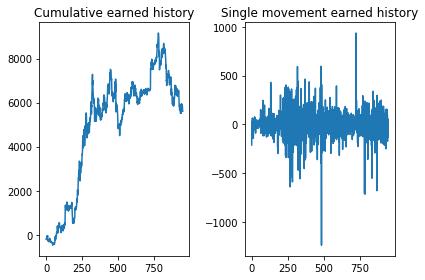

In [32]:
total_wallet_history, single_wallet_history, wallet = backtest_df(df_preds_true.dropna(), long_or_short = "short", fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [17]:
df_preds_true.dropna().iloc[1]

Close         29157.180000
Pred Close    28709.565921
Name: 2022-06-10 17:16:00, dtype: float64